## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=1
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
from data.dataset import Dataset
import data.data_selector as ds
import utils.data_processing as dp
import utils.plot_functions as pf
import analysis.analysis_picker as ap

## SMT

In [3]:
bf_loc = "/home/dpaiton/Work/SparseManifoldTransform/basis1_BIRD_dn64x_4K_revision_nature.npz"
stats_loc = "/home/dpaiton/Work/SparseManifoldTransform/basis1_BIRD_dn64x_4K_revision_nature_stats.npz"

loaded = np.load(bf_loc)
basis = loaded['basis1']
loaded.close()

bf_stats = dp.get_dictionary_stats(basis, padding=32, num_gauss_fits=50, gauss_thresh=0.3)
np.savez(stats_loc, data={"bf_stats":bf_stats})
#bf_stats = np.load(stats_loc)["data"].item()["bf_stats"]

FileNotFoundError: [Errno 2] No such file or directory: '/home/dpaiton/Work/SparseManifoldTransform/basis1_BIRD_dn64x_4K_revision_nature.npz'

In [ ]:
basis_index = 0
masked_fits = []
unmasked_fits = []
for basis_index in range(bf_stats["num_outputs"]):
  tmp_masked_fits = []
  tmp_unmasked_fits = []
  for phase in np.linspace(-np.pi, np.pi, 8):
    masked_params = dp.get_grating_params(bf_stats, bf_idx=basis_index, phase=phase)
    masked_grating = dp.generate_grating(*masked_params)
    vec1 = masked_grating.reshape(masked_grating.size).T
    vec1_norm = vec1 / np.sum(np.square(vec1))
    vec2 = bf_stats["basis_functions"][basis_index].reshape(bf_stats["basis_functions"][basis_index].size)
    vec2_norm = vec2 / np.sum(np.square(vec2))
    tmp_masked_fits.append(np.dot(vec1_norm, vec2_norm))
  
    unmasked_params = dp.get_grating_params(bf_stats, bf_idx=basis_index, diameter=-1, phase=phase)
    unmasked_grating = dp.generate_grating(*unmasked_params)
    vec1 = unmasked_grating.reshape(unmasked_grating.size).T
    vec1_norm = vec1 / np.sum(np.square(vec1))
    vec2 = bf_stats["basis_functions"][basis_index].reshape(bf_stats["basis_functions"][basis_index].size)
    vec2_norm = vec2 / np.sum(np.square(vec2))
    tmp_unmasked_fits.append(np.dot(vec1_norm, vec2_norm))
  masked_fits.append(np.max(tmp_masked_fits))
  unmasked_fits.append(np.max(tmp_unmasked_fits))

sorted_masked_fit_ids = list(np.argsort(masked_fits)[::-1].astype(int)) #descending
sorted_unmasked_fit_ids = list(np.argsort(unmasked_fits)[::-1].astype(int)) #descending
np.savez("/home/dpaiton/Work/SparseManifoldTransform/fit_qualities.npz",
  data={"masked":sorted_masked_fit_ids, "unmasked":sorted_unmasked_fit_ids})

In [ ]:
#smt_dict_fig = pf.plot_weights(np.stack([bf_stats["basis_functions"][index] for index in sorted_complete_fit_ids], axis=0),
#  title="Weights")
#smt_dict_fig.savefig("/home/dpaiton/Work/SparseManifoldTransform/paper_figs/bfs_sorted_by_fits.pdf", transparent=True, bbox_inches="tight")

In [ ]:
def plot_ellipse_summaries(bf_stats, num_bf=-1, lines=False, rand_bf=False, ids=None):
  """
  Plot basis functions with summary ellipses drawn over them
  Inputs:
    bf_stats [dict] output of dp.get_dictionary_stats()
    num_bf [int] number of basis functions to plot (<=0 is all; >total is all)
    lines [bool] If true, will plot lines instead of ellipses
    rand_bf [bool] If true, will choose a random set of basis functions
  """
  tot_num_bf = len(bf_stats["basis_functions"])
  bfs = []
  for bf in bf_stats["basis_functions"]:
    bf -= np.mean(bf)
    bf = bf / (np.max(bf)-np.min(bf))
    bfs.append(bf)
  vmin = np.min(np.stack(bfs, axis=0))
  vmax = np.max(np.stack(bfs, axis=0))
  if num_bf <= 0 or num_bf > tot_num_bf:
    num_bf = tot_num_bf
  SFs = np.asarray([np.sqrt(fcent[0]**2 + fcent[1]**2)
    for fcent in bf_stats["fourier_centers"]], dtype=np.float32)
  sf_sort_indices = np.argsort(SFs)
  if rand_bf:
    bf_range = np.random.choice([i for i in range(tot_num_bf)], num_bf, replace=False)
  num_plots_y = int(np.ceil(np.sqrt(num_bf)))
  num_plots_x = int(np.ceil(np.sqrt(num_bf)))
  gs = gridspec.GridSpec(num_plots_y, num_plots_x)
  fig = plt.figure(figsize=(17,17))
  filter_idx = 0
  for plot_id in  np.ndindex((num_plots_y, num_plots_x)):
    ax = pf.clear_axis(fig.add_subplot(gs[plot_id]))
    if filter_idx < tot_num_bf and filter_idx < num_bf:
      if rand_bf:
        bf_idx = bf_range[filter_idx]
      else:
        if ids is not None:
          bf_idx = ids[filter_idx]
        else:
          bf_idx = filter_idx
      ax.imshow(bfs[bf_idx], interpolation="Nearest", cmap="Greys_r", vmin=vmin, vmax=vmax)
      #ax.set_title(str(bf_idx), fontsize="8")
      center = bf_stats["gauss_centers"][bf_idx]
      evals, evecs = bf_stats["gauss_orientations"][bf_idx]
      orientations = bf_stats["fourier_centers"][bf_idx]
      angle = np.rad2deg(np.pi/2 + np.arctan2(*orientations))
      alpha = 1.0
      ellipse = pf.plot_ellipse(ax, center, evals, angle, color_val="b", alpha=alpha, lines=lines)
      filter_idx += 1
    ax.set_aspect("equal")
  plt.show()
  return fig

In [ ]:
fig = plot_ellipse_summaries(bf_stats, num_bf=500, lines=True, rand_bf=False, ids=sorted_unmasked_fit_ids)
fig.savefig("/home/dpaiton/Work/SparseManifoldTransform/paper_figs/unmasked_sorted_bf_fit_samples.pdf", transparent=True, bbox_inches="tight")

#fig = plot_ellipse_summaries(bf_stats, num_bf=500, lines=True, rand_bf=False, ids=sorted_masked_fit_ids)
#fig.savefig("/home/dpaiton/Work/SparseManifoldTransform/paper_figs/masked_sorted_bf_fit_samples.pdf", transparent=True, bbox_inches="tight")

#fig = plot_ellipse_summaries(bf_stats, num_bf=500, lines=True, rand_bf=False, ids=sorted_unmasked_fit_ids[::-1])
#fig.savefig("/home/dpaiton/Work/SparseManifoldTransform/paper_figs/inverse_unmasked_sorted_bf_fit_samples.pdf", transparent=True, bbox_inches="tight")

#fig = plot_ellipse_summaries(bf_stats, num_bf=500, lines=True, rand_bf=False, ids=sorted_masked_fit_ids[::-1])
#fig.savefig("/home/dpaiton/Work/SparseManifoldTransform/paper_figs/inverse_masked_sorted_bf_fit_samples.pdf", transparent=True, bbox_inches="tight")

# END SMT

In [3]:
analysis_params = {
  #"model_type": "sigmoid_autoencoder",
  #"model_name": "sigmoid_autoencoder_mnist",
  "model_type": "lca",
  "model_name": "lca",
  "version": "0.0",
  "save_info": "analysis",
  "overwrite_analysis": False}

# Computed params
analysis_params["model_dir"] = (os.path.expanduser("~")+"/Work/Projects/"+analysis_params["model_name"])

In [4]:
analyzer = ap.get_analyzer(analysis_params)
analyzer.model.setup(analyzer.model_params, analyzer.model_schedule)
analyzer.load_analysis(save_info=analysis_params["save_info"])

In [5]:
if hasattr(analyzer, "ot_grating_responses"):
  ot_bf_indices = analyzer.ot_grating_responses["neuron_indices"]
  ot_contrasts = analyzer.ot_grating_responses["contrasts"]
  ot_phases = analyzer.ot_grating_responses["phases"]
  ot_orientations = analyzer.ot_grating_responses["orientations"]
  ot_best_phases = analyzer.ot_grating_responses["best_phases"]
  ot_mean_activations = analyzer.ot_grating_responses["mean_responses"]

if hasattr(analyzer, "co_grating_responses"):
  co_bf_indices = analyzer.co_grating_responses["neuron_indices"]
  co_contrasts = analyzer.co_grating_responses["contrasts"]
  co_phases = analyzer.co_grating_responses["phases"]
  co_base_orientations = analyzer.co_grating_responses["base_orientations"]
  co_mask_orientations = analyzer.co_grating_responses["mask_orientations"]
  co_base_mean_responses = analyzer.co_grating_responses["base_mean_responses"]
  co_test_mean_responses = analyzer.co_grating_responses["test_mean_responses"]

/home/dpaiton/tensorflow/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


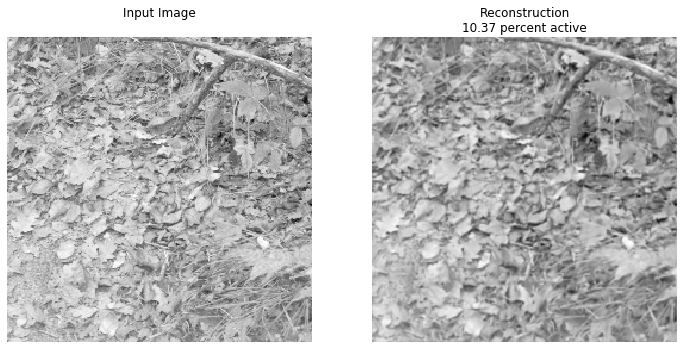

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0] = pf.clear_axis(ax[0])
ax[0].imshow(np.squeeze(analyzer.full_image), cmap="Greys_r")
ax[0].set_title("Input Image\n")
ax[1] = pf.clear_axis(ax[1])
ax[1].imshow(np.squeeze(analyzer.full_recon), cmap="Greys_r")
percent_active = "{:.2f}".format(analyzer.recon_frac_act*100)
ax[1].set_title("Reconstruction\n"+percent_active+" percent active")
plt.show()
fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params["model_name"]+"_image_recon.png", transparent=True,
  bbox_inches="tight")

SystemError: <built-in method write of _io.BufferedWriter object at 0x7fb7b302dbf8> returned a result with an error set

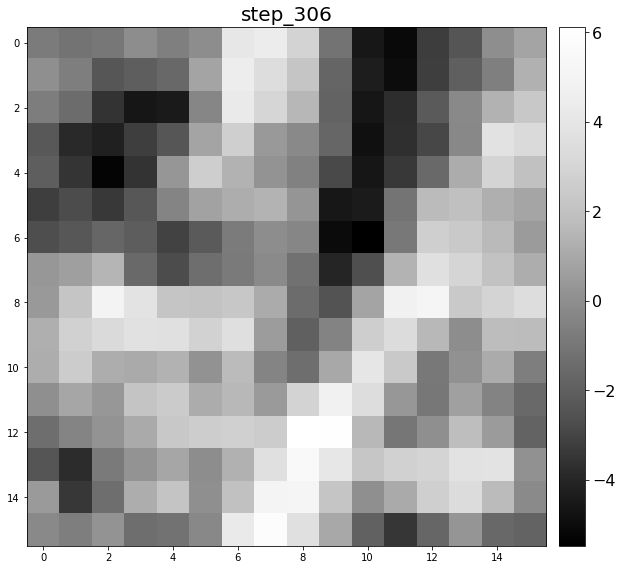

In [9]:
if not os.path.exists(analyzer.analysis_out_dir+"/vis/adversarial_recons/"):
  os.makedirs(analyzer.analysis_out_dir+"/vis/adversarial_recons/")
if not os.path.exists(analyzer.analysis_out_dir+"/vis/adversarial_stims/"):
  os.makedirs(analyzer.analysis_out_dir+"/vis/adversarial_stims/")
  
for step, recon in enumerate(analyzer.adversarial_recons):
  pf.plot_matrix(recon.reshape(int(np.sqrt(analyzer.model.num_pixels)),int(np.sqrt(analyzer.model.num_pixels))), title="step_"+str(step),
    save_filename=analyzer.analysis_out_dir+"/vis/adversarial_recons/recon_step_"+str(step)+".png")
  
for step, stim in enumerate(analyzer.adversarial_images):
  pf.plot_matrix(stim.reshape(int(np.sqrt(analyzer.model.num_pixels)),int(np.sqrt(analyzer.model.num_pixels))), title="step_"+str(step),
    save_filename=analyzer.analysis_out_dir+"/vis/adversarial_stims/stim_step_"+str(step)+".png")

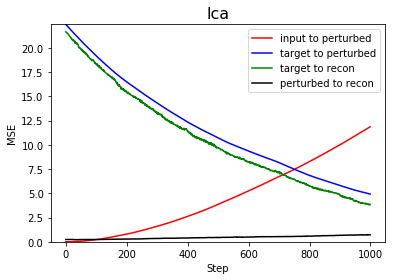

In [8]:
# TODO: Add input, target & perturbed images.
fig, ax1 = plt.subplots()
line1 = ax1.plot(analyzer.adversarial_input_adv_mses, 'r', label="input to perturbed")
ax1.tick_params('y', colors='k')
ax1.set_xlabel("Step")
ax1.set_ylabel("MSE")
ax1.set_ylim([0, np.max(analyzer.adversarial_input_adv_mses+analyzer.adversarial_target_adv_mses)])

#ax2 = ax1.twinx()
line2 = ax1.plot(analyzer.adversarial_target_adv_mses, 'b', label="target to perturbed")
#ax2.tick_params('y', colors='k')
#ax2.set_ylim(ax1.get_ylim())

#ax3 = ax1.twinx()
line3 = ax1.plot(analyzer.adversarial_target_recon_mses, 'g', label="target to recon")
#ax3.tick_params('y', colors='k')
#ax3.set_ylim(ax1.get_ylim())

line4 = ax1.plot(analyzer.adversarial_adv_recon_mses, 'k', label="perturbed to recon")

lines = line1+line2+line3+line4
line_labels = [l.get_label() for l in lines]
ax1.legend(lines, line_labels)#, loc=9)

ax1.set_title(analysis_params["model_name"], fontsize=16)

fig.savefig(analyzer.analysis_out_dir+"/vis/adversarial_losses.png")
plt.show()

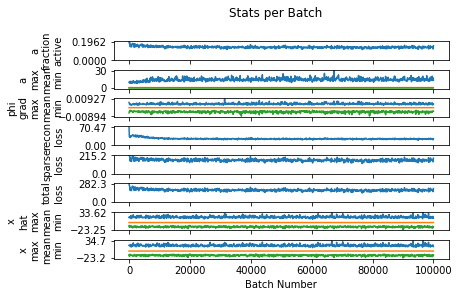

In [10]:
#keys=["a_fraction_active", "recon_loss", "sparse_loss", "total_loss"]
#labels=["activity", "recon loss", "sparse loss", "total loss"]
stats_fig = pf.plot_stats(analyzer.run_stats)#, keys=keys, labels=labels)
stats_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params["model_name"]+"_train_stats.png")

In [ ]:
atas_fig = pf.plot_data_tiled(analyzer.atas.T, normalize=False, title="Activity triggered averages on image data")
atas_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params["model_name"]+"_img_atas.png")

In [ ]:
num_noise_images = analyzer.num_noise_images
if hasattr(analyzer, "noise_activity"):
  noise_activity = analyzer.noise_activity
  noise_atas = analyzer.noise_atas
  noise_atcs = analyzer.noise_atcs
  noise_atas_fig = pf.plot_data_tiled(noise_atas.T, normalize=False, title="Activity triggered averages on standard normal noise data")
  noise_atas_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params["model_name"]+"_noise_atas.png")
  neuron_idx=0
  evals, evecs = np.linalg.eigh(noise_atcs[neuron_idx,...]) 
  top_indices = np.argsort(evals)[::-1]
  fig = pf.plot_weights(evecs.T.reshape(256,16,16)[top_indices,:,:])
  fig2 = pf.plot_eigenvalues(evals[::-1], ylim=[np.min(evals), np.max(evals)])

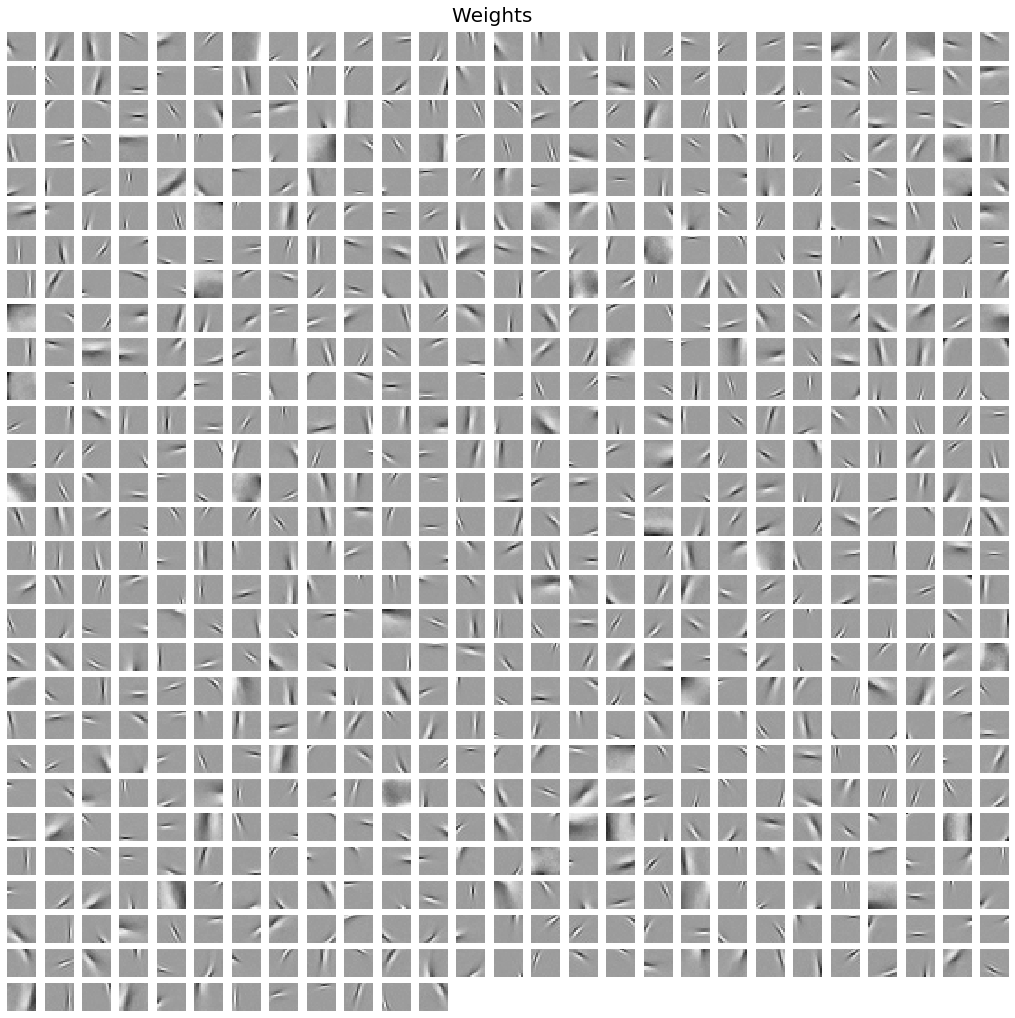

In [11]:
weight_shape = [analyzer.bf_stats["num_outputs"], analyzer.bf_stats["patch_edge_size"], analyzer.bf_stats["patch_edge_size"]]
dict_fig = pf.plot_weights(analyzer.evals["weights/phi:0"].T.reshape(weight_shape), title="Weights")
dict_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params["model_name"]+"_dict.png", transparent=True,
  bbox_inches="tight")

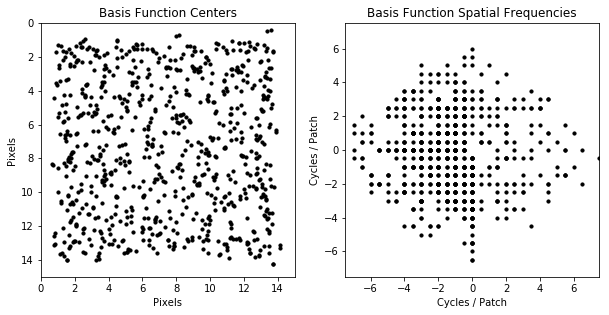

In [12]:
fig = pf.plot_loc_freq_summary(analyzer.bf_stats)
fig.savefig(analyzer.analysis_out_dir+"/vis/fig_location_frequency_centers.png")

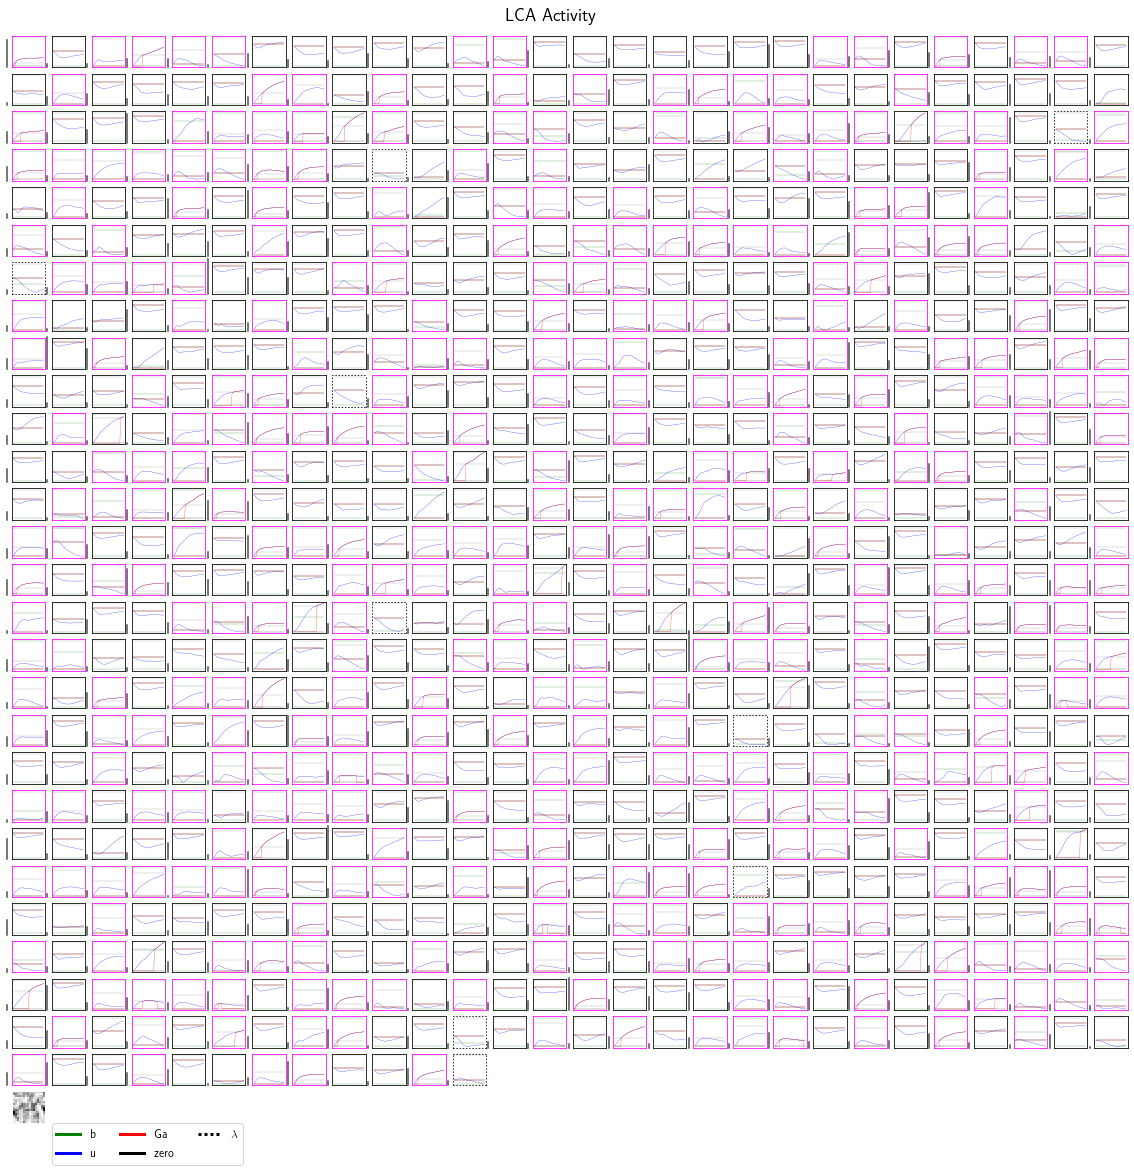

In [8]:
act_indicator_threshold = 0.80
inf_trace_fig = pf.plot_inference_traces(analyzer.inference_stats, analyzer.model_schedule[0]["sparse_mult"],
  act_indicator_threshold=act_indicator_threshold)
inf_trace_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params["model_name"]+"_inference_traces_dot_thresh-"+str(act_indicator_threshold)+"_"+analysis_params["save_info"]+".pdf")

In [ ]:
inf_stats_fig = pf.plot_inference_stats(analyzer.inference_stats, title="Loss During Inference")
inf_stats_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params["model_name"]+"_inference_loss_50_"+analysis_params["save_info"]+".png")

In [ ]:
#rectified_resp = analyzer.ot_grating_responses["rectified_responses"].reshape(2*analyzer.model_params["num_neurons"],
#  len(ot_contrasts), len(ot_orientations))
#ot_fig = pf.plot_contrast_orientation_tuning(ot_bf_indices, ot_contrasts, ot_orientations, rectified_resp)
ot_fig = pf.plot_contrast_orientation_tuning(ot_bf_indices, ot_contrasts, ot_orientations, ot_mean_activations)
ot_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params["model_name"]+"_orientation_tuning.pdf")

In [ ]:
#cross_fig = pf.plot_masked_orientation_tuning(co_bf_indices, co_mask_orientations, co_base_mean_responses, analyzer.co_grating_responses["test_mean_responses"])
cross_fig = pf.plot_masked_orientation_tuning(co_bf_indices, co_mask_orientations, co_base_mean_responses, co_test_mean_responses)
cross_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params["model_name"]+"_cross_orientation_tuning.pdf")

In [ ]:
cross_contrast_fig = pf.plot_plaid_contrast_tuning(co_bf_indices, co_contrasts, co_contrasts, co_base_orientations,
  co_mask_orientations, co_test_mean_responses)
cross_contrast_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params["model_name"]+"_cross_contrast_orientation_tuning.pdf")

In [ ]:
#grating = lambda bf_idx,orientation,phase,contrast:dp.generate_grating(
#  *dp.get_grating_params(bf_stats=analyzer.bf_stats, bf_idx=bf_idx, orientation=orientation,
#  phase=phase, contrast=contrast, diameter=-1)).reshape(16,16)
#
#bf_idx = 29
#bf = analyzer.evals["weights/phi:0"].T[co_bf_indices[bf_idx],:].reshape(16,16)
#base_stim = grating(co_bf_indices[bf_idx], co_base_orientations[bf_idx], co_phases[0], 0.5)
#mask_stim = grating(co_bf_indices[bf_idx], orthogonal_orientations[bf_idx], co_phases[5], 0.5)
#test_stim = base_stim + mask_stim
#
#all_min = np.min(np.stack([base_stim, mask_stim, test_stim]))
#all_max = np.max(np.stack([base_stim, mask_stim, test_stim]))
#
#fig, axes = plt.subplots(4)
#axes[0] = pf.clear_axis(axes[0])
#axes[1] = pf.clear_axis(axes[1])
#axes[2] = pf.clear_axis(axes[2])
#axes[3] = pf.clear_axis(axes[3])
#axes[0].imshow(bf, cmap="Greys_r")
#axes[1].imshow(base_stim, cmap="Greys_r", vmin=all_min, vmax=all_max)
#axes[2].imshow(mask_stim, cmap="Greys_r", vmin=all_min, vmax=all_max)
#axes[3].imshow(test_stim, cmap="Greys_r", vmin=all_min, vmax=all_max)
#plt.show()
#fig.savefig("/home/dpaiton/tmp_figs/"+analysis_params["model_name"]+"_ex_cross_stim.png")

In [ ]:
#constructed_bfs = np.zeros_like(analyzer.evals["weights/phi:0"].T)
#for bf_idx in range(constructed_bfs.shape[0]):
#  params = dp.get_grating_params(analyzer.bf_stats, bf_idx)
#  grating = dp.generate_grating(*params)
#  constructed_bfs[bf_idx,...] = grating.reshape(256)
#fig = pf.plot_data_tiled(constructed_bfs)

### compute iso_response_contrast curves

In [ ]:
outputs = analyzer.iso_response_contrasts(analyzer.bf_stats, base_contrast=0.5, contrast_resolution=0.01,
  closeness=0.01, num_alt_orientations=4, orientations=np.linspace(0.0, np.pi, 16),
  phases = np.linspace(-np.pi, np.pi, 12), neuron_indices=[52,53,54], diameter=-1,
  scale=analyzer.analysis_params["input_scale"])

In [ ]:
outputs["iso_response_parameters"][0]